# **<u>Flujo de trabajo para crear cuadrículas con Python</u>**

---

* La idea es crear cuadrículas para los Espacios Naturales Protegidos de la isla de Gran Canaria usando Python, garantizando la reproducibilidad de la creación de estas cuadrículas. 

---

In [2]:
## Librerías a usar:
import os
import requests
from zipfile import ZipFile
import geopandas as gpd
import pandas as pd
from shapely.geometry import box

## **Descargar datos IDECanarias y REGCAN95 1 Km**

### Capa a usar: <u>**Red de Espacios Naturales Protegidos de Canarias (ENP)**</u>

Además descargar la malla de **REGCAN95** que es la malla (en este caso usaremos cuadrículas 1 x 1Km) que usa Biota para la creación de las cuadrículas 500 x 500 m. 

* *La suma de la capa del Espacio Natural Protegido + la malla REGCAN95 se usarán como base para crear las cuadrículas.*

In [3]:
## Variables para la descarga de datos definiendo rutas y URL del archivo
# URL de los ENP en IDECanarias, datos públicos
url_enp = "https://opendata.sitcan.es/upload/medio-ambiente/eennpp.zip"
# URL de la Malla 1 km x 1km
url_malla = "https://www.miteco.gob.es/content/dam/miteco/es/biodiversidad/servicios/banco-datos-naturaleza/malla1x1_70_tcm30-199176.zip"
carpeta_data = "data/"
carpeta_destino = "data/enps_canarias/"
ruta_zip_enps = os.path.join(carpeta_data, "enps_canarias/enp.zip")
ruta_zip_grid = os.path.join(carpeta_data, "enps_canarias/malla.zip")

def download_data(url, ruta_zip):
    ## Creamos la carpeta de destino ("data") si todavía no existe
    for carpeta in [carpeta_data, carpeta_destino]:
        os.makedirs(carpeta, exist_ok=True)

    ## Proceso para descargar el archivo
    response = requests.get(url=url)
    with open(ruta_zip, "wb") as file:
        file.write(response.content)

    ## Proceso para descomprimir el archivo
    with ZipFile(ruta_zip, "r") as archivo_zip:
        archivo_zip.extractall(carpeta_destino)

for url,ruta in zip([url_enp, url_malla], [ruta_zip_enps, ruta_zip_grid]):
    download_data(url=url, ruta_zip=ruta)

print(f"""
> Archivos  descargado y descomprimido en '{carpeta_destino}'
> esta es la lista de los archivos de la carpeta: 
{os.listdir("data/enps_canarias/")}
""")


> Archivos  descargado y descomprimido en 'data/enps_canarias/'
> esta es la lista de los archivos de la carpeta: 
['eennpp.dbf', 'eennpp.prj', 'eennpp.shp', 'eennpp.shx', 'enp.zip', 'malla.zip', 'malla1x1_70.dbf', 'malla1x1_70.prj', 'malla1x1_70.sbn', 'malla1x1_70.sbx', 'malla1x1_70.shp', 'malla1x1_70.shp.xml', 'malla1x1_70.shx']



## **Preprocesado de la capa SHP**

1. Se filtrará de la capa SHP de los ENP de Canarias para obtener específicamente un archivo SHP de los <u>**ENP de Gran Canaria**</u>

2. Se filtrará de la Malla REGCAN 1 x 1 Km aquellas que coincidan con el **<u>ENP seleccionado</u>**

In [4]:
## Leemos la capa de la malla 1 x 1 Km
grid = gpd.read_file("data/enps_canarias/malla1x1_70.shp")
grid.head(n = 3)

,OBJECTID,X,Y,HUSO,ZONA,CUADRI100,CUADRI10,NUTM,COD100X100,COD10X10,...,UTMCODE1X1,COD1X1,PERIM_KM,AREA_KM2,COD_INB,XCENTROIDE,YCENTROIDE,Shape_Leng,Shape_Area,geometry
0,1,4,5,28,R,FT,45,4455,28RFT,28RFT45,...,FT4455,28RFT4455,4.0,1.0,28RFT4455,644500.0,3255500.0,4000.0,1000000.0,"POLYGON ((644000.000 3256000.000, 645000.000 3..."
1,2,5,5,28,R,FT,45,4555,28RFT,28RFT45,...,FT4555,28RFT4555,4.0,1.0,28RFT4555,645500.0,3255500.0,4000.0,1000000.0,"POLYGON ((645000.000 3256000.000, 646000.000 3..."
2,3,3,4,28,R,FT,45,4354,28RFT,28RFT45,...,FT4354,28RFT4354,4.0,1.0,28RFT4354,643500.0,3254500.0,4000.0,1000000.0,"POLYGON ((643000.000 3255000.000, 644000.000 3..."


In [5]:
## Cargamos los datos de los ENP de Canarias
enps_canarias = gpd.read_file("data/enps_canarias/eennpp.shp")
enps_canarias.head() ## vemos los primeros valores

,codigo,categoria,nombre,geometry
0,H-6,Paisaje Protegido,Ventejís,"POLYGON ((207380.300 3077264.524, 207361.430 3..."
1,H-7,Paisaje Protegido,Timijiraque,"POLYGON ((212318.690 3076408.720, 212322.130 3..."
2,H-3,Reserva Natural Especial,Tibataje,"POLYGON ((205028.180 3074960.459, 205020.849 3..."
3,H-2,Reserva Natural Integral,Roques de Salmor,"MULTIPOLYGON (((205086.150 3081134.320, 205088..."
4,H-5,Monumento Natural,Las Playas,"MULTIPOLYGON (((209998.290 3070692.910, 209998..."


In [6]:
## Filtramos del campo "codigo" aquellos que empiecen por la letra "C" (Gran Canaria)
enps_gran_canaria = enps_canarias[enps_canarias["codigo"].str.startswith("C")]
## Vemos de nuevo los primeros valores para ver los valores "C" de Gran Canaria en "codigo" 
enps_gran_canaria.head()

,codigo,categoria,nombre,geometry
20,C-32,Sitio de Interés Científico,Juncalillo del Sur,"POLYGON ((453679.696 3074570.097, 453669.984 3..."
21,C-31,Sitio de Interés Científico,Roque de Gando,"POLYGON ((464665.536 3090497.440, 464658.994 3..."
22,C-30,Sitio de Interés Científico,Tufia,"POLYGON ((462277.610 3093302.880, 462281.280 3..."
23,C-29,Sitio de Interés Científico,Jinámar,"POLYGON ((460256.224 3101297.088, 460260.274 3..."
24,C-28,Paisaje Protegido,Montaña de Agüimes,"POLYGON ((458220.295 3087279.345, 458220.210 3..."


## **Procesado de la capa anterior**

Debido a que algunos espacios se superponen con otros y dan resultados extraños

In [7]:
filtrado1 = enps_gran_canaria[enps_gran_canaria["codigo"].isin([
      "C-01", "C-21", "C-20", 
      "C-14", "C-15", "C-02", 
      "C-05", "C-04"
])] 

filtrado2 = gpd.overlay(enps_gran_canaria, filtrado1, how="difference")

enps_gran_canaria_procesado = pd.concat([filtrado1, filtrado2], ignore_index=True)

enps_gran_canaria_procesado.head()

,codigo,categoria,nombre,geometry
0,C-15,Monumento Natural,Montañón Negro,"POLYGON ((438770.784 3102164.576, 438768.340 3..."
1,C-14,Monumento Natural,Bandama,"POLYGON ((454972.768 3102114.880, 454980.146 3..."
2,C-05,Reserva Natural Especial,Los Tilos de Moya,"POLYGON ((441378.976 3107781.184, 441376.329 3..."
3,C-20,Monumento Natural,Riscos de Tirajana,"POLYGON ((443999.731 3093268.623, 443999.500 3..."
4,C-04,Reserva Natural Especial,Azuaje,"POLYGON ((443793.984 3109274.592, 443797.298 3..."


In [8]:
## Selecciona el ENP que quiereas filtrar
enp_seleccion = "C-29"

enp_seleccionado = enps_gran_canaria_procesado[enps_gran_canaria_procesado["codigo"] == enp_seleccion]

## Tabla de Espacios que has seleccionado para generar cuadrículas
enp_seleccionado

,codigo,categoria,nombre,geometry
11,C-29,Sitio de Interés Científico,Jinámar,"POLYGON ((460256.224 3101297.088, 460260.274 3..."


<Axes: >

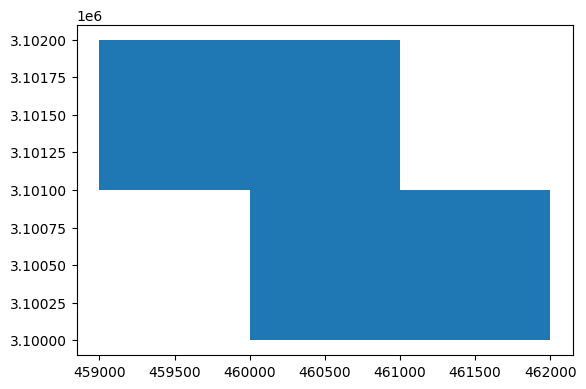

In [9]:
## Filtrar la malla aquellas cuadrículas que coincidan con el ENP
grid_filtrado = grid[grid.intersects(enp_seleccionado.unary_union)]
grid_filtrado.plot()

### **Crear la capa de cuadrículas**

* Se hará una función para cuyo objetivo sea la creación de una capa de cuadrículas para un GeoDataFrame especificado

In [10]:
def crear_cuadriculas(gdf, tamanio):
    """Resumen
    Función para crear mapa de cuadrículas de espacios naturales protegidos

    Args:
        gdf (GeoDataFrame): GeoDataFrame de 
        tamanio (int): tamaño de las cuadrículas

    Returns:
        GeoDataFrame: GeoDataFrame del espacio protegido dividido en cuadrículas con tamaño específico
    """
    # Crear las separaciones para los municipios de Gran Canaria
    minx, miny, maxx, maxy = gdf.total_bounds

    # Generar una lista con las cuadrículas
    boxes = []
    x = minx
    while x < maxx:
        y = miny
        while y < maxy:
            boxes.append(box(x, y, x + tamanio, y + tamanio))
            y += tamanio
        x += tamanio

    grid = gpd.GeoDataFrame({'geometry': boxes}, crs=gdf.crs)

    return grid

## Crear una capa SHP de cuadrículas del espacio natural seleccionado


Ejemplo para cuadrículas de 50 m x 50 m

```
## Seleccionar el tamaño de las cuadrículas. ej: 50 sería 50 m x 50 m 
tamanio = tamanio_cuadriculas = 50

## Usamos la función para crear cuadrículas en el grid filtrado de 1 km x 1km en base al ENP seleccionado
grid_selected = crear_cuadriculas(grid_filtrado, tamanio)
## Filtramos las cuadrículas en contacto con el ENP ()
enp_grid = grid_selected[grid_selected.intersects(enp_seleccionado.unary_union)]
## Creamos una columna de valores con el número de cuadrículas 
enp_grid["cuadricula"] = ["cuadricula-" + str(i) for i in range(1,(len(enp_grid) + 1),1)]
## Descargamos el SHP
enp_grid.to_file(f"results/{enp_seleccion}.shp")
```

In [11]:
tamanio = tamanio_cuadriculas = 50

grid_selected = crear_cuadriculas(grid_filtrado, tamanio)
enp_grid = grid_selected[grid_selected.intersects(enp_seleccionado.unary_union)]
enp_grid["cuadricula"] = ["cuadricula-" + str(i) for i in range(1,(len(enp_grid) + 1),1)]
enp_grid.to_file(f"results/{enp_seleccion}.shp")

C:\Users\jcge9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Ver si las cuadrículas son correctas en un mapa simple:

<Axes: >

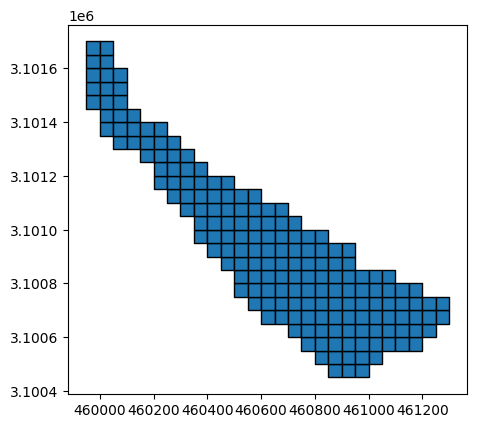

In [12]:
enp_grid.plot(edgecolor="black")